# MNIST Keras Beispiel

Erstellt am 15.8.2022

@author: stefan.kray, sascha.seifert

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import datetime

ImportError: cannot import name 'keras' from 'tensorflow' (unknown location)

### MNIST Daten laden

In [ ]:
(ds_validate,ds_test,ds_train), ds_info = tfds.load(
    'mnist',
    split=['train[:10%]','train[10%:20%]','train[20%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    data_dir="tensorflow_datasets"
)

### Daten vorbereiten

In [ ]:
batch_size=128

# Konvertierung von uint8 Bild nach float32 Daten
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

# Aufruf für alle Pixel
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

# Daten in Memory laden
ds_train = ds_train.cache()
# Daten shufflen in Memory 
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)

# Batches herstellen mit jeweils 128 Bildern
ds_train = ds_train.batch(batch_size)
# Vorhalten von Daten für bessere Performanz, Autotune=dynamischer Puffer
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Normalisierung des validate Datensatzes
ds_validate = ds_validate.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_validate = ds_validate.batch(batch_size)
ds_validate = ds_validate.cache()
ds_validate = ds_validate.prefetch(tf.data.AUTOTUNE)

# Normalisierung des test Datensatzes
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

### Trainingsdaten anzeigen

label: 4
2
<bound method DatasetV2.batch of <PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>>


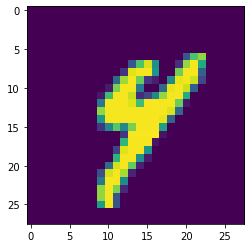

In [ ]:
l=list(ds_train.as_numpy_iterator())
# l: 469 batches x 2 Einträge (0: Bild, 1: Label) x 128 (batch size)
plt.imshow(l[0][0][5])
print("label:",l[0][1][5])
print(l[2][1][5])
print(ds_train.batch)

### Modell erstellen und trainieren

In [ ]:
input_shape = ds_info.features['image'].shape
input_shape

(28, 28, 1)

In [ ]:
model = keras.Sequential(
    [
        layers.InputLayer(input_shape), # notwendig für summary()
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.05),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.05),
        layers.Dense(10, activation="softmax"),
    ]
)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

In [ ]:
# model kompilieren und Training starten
from gc import callbacks

max_epochs=24

if model: # auf None prüfen
    model.compile(
        #optimizer=keras.optimizers.Adam(0.005),
        optimizer=keras.optimizers.Adadelta(1.0),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    # Callbacks für TensorBoard-Aufzeichnung
    log_dir = "./logs/fit/mnist_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    model.fit(
        ds_train,
        epochs=max_epochs,
        validation_data=ds_validate,
        callbacks=[tensorboard_callback]
    )



Epoch 1/24
375/375 [==============================] - 7s 17ms/step - loss: 0.2642 - sparse_categorical_accuracy: 0.9167 - val_loss: 0.0766 - val_sparse_categorical_accuracy: 0.9777
Epoch 2/24
375/375 [==============================] - 6s 16ms/step - loss: 0.0678 - sparse_categorical_accuracy: 0.9788 - val_loss: 0.0580 - val_sparse_categorical_accuracy: 0.9833
Epoch 3/24
375/375 [==============================] - 6s 16ms/step - loss: 0.0463 - sparse_categorical_accuracy: 0.9859 - val_loss: 0.0565 - val_sparse_categorical_accuracy: 0.9818
Epoch 4/24
375/375 [==============================] - 6s 16ms/step - loss: 0.0353 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.0510 - val_sparse_categorical_accuracy: 0.9845
Epoch 5/24
375/375 [==============================] - 6s 16ms/step - loss: 0.0283 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.0413 - val_sparse_categorical_accuracy: 0.9885
Epoch 6/24
375/375 [==============================] - 6s 16ms/step - loss: 0.0241 - sparse_cate

In [ ]:
# Gesamte Modell speichern
model.save("mnist_cnn.h5")    

### Ergebnisse analysieren

In [ ]:
# list all data in history
print(model.history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


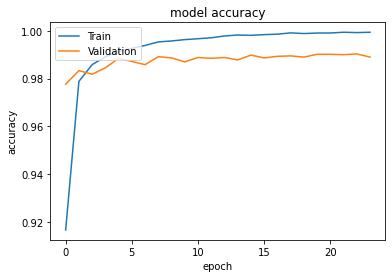

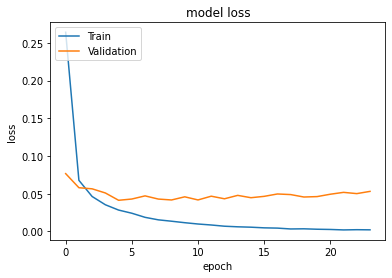

In [ ]:
# summarize history for accuracy
plt.plot(model.history.history['sparse_categorical_accuracy'])
plt.plot(model.history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### Modell testen

In [ ]:
print("final loss and accuracy on test set:",model.evaluate(ds_test))

47/47 [==============================] - 0s 8ms/step - loss: 0.0537 - sparse_categorical_accuracy: 0.9903
final loss and accuracy on test set: [0.05366659536957741, 0.9903333187103271]


### TensorBoard
Alternativ kann man auch das TensorBoard benutzen, um tiefere Einblicke in das Training zu bekommen. Voraussetzung ist, dass ein Callback bei fit() mitgegeben wird.

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir './logs/fit'



### Feature Maps visualisieren

In [ ]:
model2=keras.Model(inputs=model.inputs,outputs=model.layers[0].output)
feature_map=model2.predict(l[0][0][5:6]) #(1,26,26,32)
feature_map.shape

(1, 26, 26, 32)

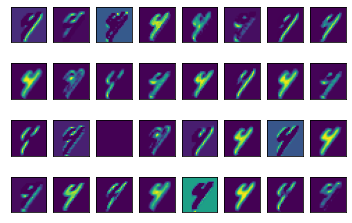

In [ ]:
# plot all 32 maps 
ix = 1
for _ in range(8):
    for _ in range(4):
        # specify subplot and turn of axis
        ax = plt.subplot(4, 8, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        ax.imshow(feature_map[0, :, :, ix-1])
        ix += 1
# show the figure
plt.show()

Alle Gewichte der 32 Filter des ersten Conv-Layers visualisieren. Nach Faltung mit diesen Filtern erhält man obige Feature-Maps.

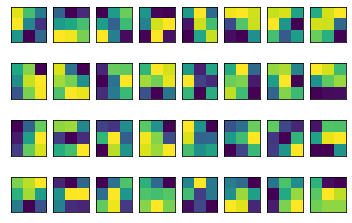

In [ ]:
w=model.layers[0].get_weights()

# plot all 32 maps of weights
ix = 1
for _ in range(8):
    for _ in range(4):
        # specify subplot and turn of axis
        ax = plt.subplot(4, 8, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        ax.imshow(w[0][:, :, :, ix-1])
        ix += 1
# show the figure
plt.show()